In [1]:
# !pip install hurst
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from hurst import compute_Hc
import time
from scipy.stats import skew, kurtosis
import warnings
from sklearn.decomposition import PCA
from scipy.signal import spectrogram


# import torch.nn as nn
# import torch
# from torch.utils.data import DataLoader, TensorDataset

warnings.filterwarnings("ignore")


In [2]:
# Ketan's paths
EEG_PATH = '/Users/ketanjaltare1/Desktop/Competitions/hms-harmful-brain-activity-classification/train_eegs/'
SPEC_PATH = '/Users/ketanjaltare1/Desktop/Competitions/hms-harmful-brain-activity-classification/train_spectrograms/'
DIRECTORY = ''

In [6]:
# Fabien's paths
EEG_PATH = 'D:/Kaggle/2024/Harmful_brain_activity_classification/train_eeg/'
SPEC_PATH = ''
DIRECTORY = 'D:/Kaggle/2024/Harmful_brain_activity_classification/'

In [4]:
# Functions to load a single dataset
train = pd.read_csv(DIRECTORY + 'train.csv')
train.head(10)

,eeg_id,eeg_sub_id,eeg_label_offset_seconds,spectrogram_id,spectrogram_sub_id,spectrogram_label_offset_seconds,label_id,patient_id,expert_consensus,seizure_vote,lpd_vote,gpd_vote,lrda_vote,grda_vote,other_vote
0,1628180742,0,0.0,353733,0,0.0,127492639,42516,Seizure,3,0,0,0,0,0
1,1628180742,1,6.0,353733,1,6.0,3887563113,42516,Seizure,3,0,0,0,0,0
2,1628180742,2,8.0,353733,2,8.0,1142670488,42516,Seizure,3,0,0,0,0,0
3,1628180742,3,18.0,353733,3,18.0,2718991173,42516,Seizure,3,0,0,0,0,0
4,1628180742,4,24.0,353733,4,24.0,3080632009,42516,Seizure,3,0,0,0,0,0
5,1628180742,5,26.0,353733,5,26.0,2413091605,42516,Seizure,3,0,0,0,0,0
6,1628180742,6,30.0,353733,6,30.0,364593930,42516,Seizure,3,0,0,0,0,0
7,1628180742,7,36.0,353733,7,36.0,3811483573,42516,Seizure,3,0,0,0,0,0
8,1628180742,8,40.0,353733,8,40.0,3388718494,42516,Seizure,3,0,0,0,0,0
9,2277392603,0,0.0,924234,0,0.0,1978807404,30539,GPD,0,0,5,0,1,5


In [5]:
# dataframe dimensiosn
print(train.shape)

# For eeg data
def loadeeg(path):
    eeg = pd.read_parquet(path)
#     eeg = eeg.replace(np.nan, 0) # There are missing values in some files. It makes the PCA analysis fail, so we need to replace them. I have chosen 0 for practicality
    return (eeg)

# For spectrograms
def loadspect(GET_ROW):
    
    row = train.iloc[GET_ROW]
#     Needs to be changed to match the eeg function
    spectrogram = pd.read_parquet(f'{SPEC_PATH}{row.spectrogram_id}.parquet')
    spec_offset = int( row.spectrogram_label_offset_seconds )
    spectrogram = spectrogram.loc[(spectrogram.time>=spec_offset)
                         &(spectrogram.time<spec_offset+600)]
    time = (np.linspace(0,600,spectrogram.shape[0])) - 25

    return (row,spectrogram,time)


(106800, 15)


# Compute time domain features

In [20]:
# Initialise a few things
time_eeg = np.arange(-25, 25+ (1/200), (1/200))
start = np.argmin(np.abs(time_eeg+5))
stop = np.argmin(np.abs(time_eeg-5))

train_grby = train.groupby("eeg_id")
train_grby.head()


,eeg_id,eeg_sub_id,eeg_label_offset_seconds,spectrogram_id,spectrogram_sub_id,spectrogram_label_offset_seconds,label_id,patient_id,expert_consensus,seizure_vote,lpd_vote,gpd_vote,lrda_vote,grda_vote,other_vote
0,1628180742,0,0.0,353733,0,0.0,127492639,42516,Seizure,3,0,0,0,0,0
1,1628180742,1,6.0,353733,1,6.0,3887563113,42516,Seizure,3,0,0,0,0,0
2,1628180742,2,8.0,353733,2,8.0,1142670488,42516,Seizure,3,0,0,0,0,0
3,1628180742,3,18.0,353733,3,18.0,2718991173,42516,Seizure,3,0,0,0,0,0
4,1628180742,4,24.0,353733,4,24.0,3080632009,42516,Seizure,3,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
106789,351917269,0,0.0,2147388374,0,0.0,429140316,10351,LRDA,0,0,0,3,0,0
106790,351917269,1,2.0,2147388374,1,2.0,1916299616,10351,LRDA,0,0,0,3,0,0
106791,351917269,2,4.0,2147388374,2,4.0,1085988029,10351,LRDA,0,0,0,3,0,0
106792,351917269,3,6.0,2147388374,3,6.0,3808975447,10351,LRDA,0,0,0,3,0,0


(18000, 20)
RangeIndex(start=0, stop=18000, step=1)


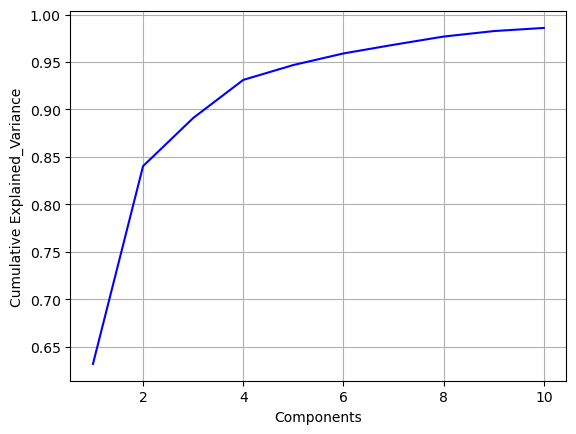

In [8]:
i = 0

path = f'{EEG_PATH}{1628180742}.parquet'
fulleeg = loadeeg(path)
print(fulleeg.shape)
print(fulleeg.index)

n = 10
pca = PCA(n)
pcafit = pca.fit_transform(fulleeg)

pca.explained_variance_ratio_
ev = np.cumsum(pca.explained_variance_ratio_)

plt.plot(range(1,n+1),ev, "b-")
plt.xlabel('Components')
plt.ylabel('Cumulative Explained_Variance')
plt.grid()
plt.show()
plt.close()

# selection 10 components for ~98% of the explained variance

In [67]:
def hurst_fct(x):
    try:
        out = compute_Hc(x, simplified=True)[0]
    except:
        out = np.nan
    return out
        

In [69]:
channels_id = pd.Series(['Fp1', 'F3', 'C3', 'P3', 'F7', 'T3', 'T5', 'O1', 'Fz', 'Cz', 'Pz', 'Fp2', 'F4', 'C4', 'P4', 'F8', 'T4', 'T6', 'O2', 'EKG'])
segment_names = {-1:"_before",0:"_during",1:"_after"}
var = ['eeg_label_offset_seconds']

n_comp = 10
PCA_columns = pd.Series(range(0,n_comp)).apply(lambda x: 'pca' + str(x)).to_list()

# I add the names of the columns here to not calculate it within the for loop. 
colnames = ['pca0_mean', 'pca0_std', 'pca0_kurt', 'pca0_skew', 'pca0_rng', 'pca0_linelength', 'pca0_rms', 'pca0_hurst', 'pca1_mean', 'pca1_std',
            'pca1_kurt', 'pca1_skew', 'pca1_rng', 'pca1_linelength', 'pca1_rms', 'pca1_hurst', 'pca2_mean', 'pca2_std', 'pca2_kurt', 'pca2_skew',
            'pca2_rng', 'pca2_linelength', 'pca2_rms', 'pca2_hurst', 'pca3_mean', 'pca3_std', 'pca3_kurt', 'pca3_skew', 'pca3_rng', 'pca3_linelength',
            'pca3_rms', 'pca3_hurst', 'pca4_mean', 'pca4_std', 'pca4_kurt', 'pca4_skew', 'pca4_rng', 'pca4_linelength', 'pca4_rms', 'pca4_hurst',
            'pca5_mean', 'pca5_std', 'pca5_kurt', 'pca5_skew', 'pca5_rng', 'pca5_linelength', 'pca5_rms', 'pca5_hurst', 'pca6_mean', 'pca6_std',
            'pca6_kurt', 'pca6_skew', 'pca6_rng', 'pca6_linelength', 'pca6_rms', 'pca6_hurst', 'pca7_mean', 'pca7_std', 'pca7_kurt', 'pca7_skew',
            'pca7_rng', 'pca7_linelength', 'pca7_rms', 'pca7_hurst', 'pca8_mean', 'pca8_std', 'pca8_kurt', 'pca8_skew', 'pca8_rng', 'pca8_linelength',
            'pca8_rms', 'pca8_hurst', 'pca9_mean', 'pca9_std', 'pca9_kurt', 'pca9_skew', 'pca9_rng', 'pca9_linelength', 'pca9_rms', 'pca9_hurst', 'segments']


n_parquet = 173 # 0:173 is ~1% of the dataset
mask = train.eeg_id.isin(train.eeg_id.unique()[0:n_parquet])
TD_Features_wf = train.loc[mask, ['eeg_id']].copy()
TD_Features_lf = pd.DataFrame({"dummy": np.zeros(len(TD_Features_wf)*3)})

t = time.time()

# Loop over each row of the train set
for count, id in enumerate(train.eeg_id.unique()[0:n_parquet]):
    if count%10 == 0: print(count)
    
    path = f'{EEG_PATH}{id}.parquet'
    fulleeg = loadeeg(path)
    pca = PCA(n) 
    pcaeeg = pd.DataFrame(pca.fit_transform(fulleeg)) # We need to exclude the ECG channel from the PCA. 
    pcaeeg.columns = PCA_columns

    for i, offset in train_grby.get_group(id)[var].itertuples():

        eeg = pcaeeg.loc[offset*200:((offset+50)*200)].copy().reset_index(drop = True)
        eeg.loc[:start-1, 'segments'] = -1 # before
        eeg.loc[start:stop-1, 'segments'] = 0 # during
        eeg.loc[stop:, 'segments'] = 1 # after
        
        eeg_by_seg = eeg.groupby(by ='segments')

        features = eeg_by_seg.agg([("mean",np.mean), 
                ("std", np.std), 
                ("kurt", kurtosis), 
                ("skew",skew), 
                ('rng', lambda x: np.max(x)-np.min(x)),
                ('linelength', lambda x: np.sum(np.abs(np.diff(x)))),
                ('rms', lambda x: np.mean(x**2)**(0.5)),
                ("hurst",lambda x: hurst_fct(x))])
                #  x in lambda x inside the agg function is a column. SVD Entropy requires the entire dataframe as input, not just a columns, so I could not make a function suited for agg.

        features['segments'] = [-1,0,1]
        TD_Features_lf.loc[i*3:i*3+2,colnames] = features.values


TD_Features_lf = TD_Features_lf.drop("dummy", axis = 1)
                                    
for i in [-1,0,1]:
    colnames = TD_Features_lf.columns + segment_names[i]
    mask = TD_Features_lf.segments == i
    TD_Features_wf[colnames] = TD_Features_lf.loc[mask,:].reset_index(drop = True)

TD_Features_wf = TD_Features_wf.drop(["segments_before", "segments_during", "segments_after"], axis = 1)

print(f"Running time: {time.time()-t} s")

# I find a running time of 1730.8 seconds for 173 parquet files (1% of all parquet files) and 1725 rows (~1.6% of the rows in train). 
# This means that for all parquet files, it should take approximately 29h45h. It's a considerable improvement compared to the initial 400+ hours, 
# but it's still a lot. I haven't tried multithreading, so this could be an option. One core to open the parquet file, another core to process its content. 
# There are ~2640 parquet files in the hidden test data: https://www.kaggle.com/competitions/hms-harmful-brain-activity-classification/discussion/471287
# It means that the computation time for the test set could be between 1h35 (considering the time per row and assuming ~16300 rows in the test set)
# and 7h50 (considering the time per parquet file). Let's keep in mind that this is only with time domain features. 

# Edit1: filling the wide format dataframe outside of the loop saves 1.8 s per 17 parquet files and/or per 200 lines.
# Edit2: I encountered an error between trials 60 and 70 for the compute_Hc function, hence the use of hurst_fct.
#        The error message is: invalid value encountered in double_scalars

# Comment_KJ: We should exclude the ECG channel from the PCA in the loop. I have not changed it because we need to also add it back after the PCA. 
# Didnt want to change the code too much for now. ## Comment FP: Ok, I will correct that. We need to rethink PCA anyway.

0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
Running time: 1730.8352348804474 s


In [ ]:
# SVD Entropy
# eeg_z = (eeg_seg-eeg_seg.mean())/eeg_seg.std()
#u, s, v = np.linalg.svd(eeg_z, full_matrices=True)
# s = s/np.sum(s)
#TD_Features.loc[i, channels+"_SVDEn_"+ segment_names[seg]] = -(s*np.log(s)).sum()
# linelength['SVDEn' + seg] = SVDEn

# # Entropy
# add = eeg.sum()
# eegnorm = eeg/add
# entropy = -(eegnorm*np.log(eegnorm)).sum() # There may be problems here with the log.
# entropy.index = entropy.index + '_entropy' + seg
# entropy = entropy.to_frame().transpose()

# Hurst Exponent
# hurst = []
#for idx,channel in enumerate(eeg.keys()):
#    h, c, data = compute_Hc(eeg[channel], simplified=True)
#    hurst.append(h)
# hurst = pd.DataFrame([np.array(hurst).reshape(-1)], columns=(eeg.keys()+ 'hurst' + seg))

In [70]:
print(TD_Features_lf.shape)
print(TD_Features_wf.shape)

(5175, 81)
(1725, 241)


In [71]:
TD_Features_lf.tail(20)

,pca0_mean,pca0_std,pca0_kurt,pca0_skew,pca0_rng,pca0_linelength,pca0_rms,pca0_hurst,pca1_mean,pca1_std,...,pca8_hurst,pca9_mean,pca9_std,pca9_kurt,pca9_skew,pca9_rng,pca9_linelength,pca9_rms,pca9_hurst,segments
5155,-6268.035156,171.255099,0.279446,0.450964,1096.448242,95120.335938,6270.372876,0.348803,-302.324097,78.507224,...,0.463439,1.774949,17.577792,0.477963,-0.065862,112.140091,6288.990234,17.662806,0.366965,0.0
5156,-6253.765625,138.223448,-0.342571,0.084768,877.630371,204197.765625,6255.292159,0.259031,-305.355225,80.887989,...,0.366676,2.708290,20.221761,0.689814,-0.016549,126.768631,11586.338867,20.399809,0.341931,1.0
5157,9.742727,93.714630,0.401158,0.026201,758.416870,36551.984375,94.208053,0.363486,1.462206,89.722160,...,0.280688,0.159053,8.873723,0.226633,0.088045,67.275063,7895.468750,8.874039,0.293829,-1.0
5158,-45.094505,97.215984,-0.066720,-0.047188,535.239929,17915.824219,107.143531,0.396517,2.212581,88.698395,...,0.387380,1.274808,9.519106,1.014411,0.031132,68.790161,4027.483887,9.601729,0.345428,0.0
5159,12.804525,87.719876,-0.206660,-0.259130,524.554199,33102.226562,88.638643,0.341758,-2.568498,81.229003,...,0.329724,-0.796456,11.207109,-0.457457,0.149174,64.175125,8927.796875,11.233977,0.262125,1.0
5160,0.482524,158.433302,10.056246,-1.824123,1857.841431,327097.375000,158.414230,0.286890,-0.936888,85.481165,...,0.237943,1.132171,9.500902,-0.169676,0.024462,68.224197,22539.421875,9.566943,0.212545,-1.0
5161,3.018477,158.030864,10.210512,-1.864832,1891.890625,164967.406250,158.020185,0.330023,3.050642,99.687885,...,0.282965,-1.089817,9.617920,0.305404,0.228404,69.945534,11447.889648,9.677077,0.227924,0.0
5162,-1.991764,162.228563,10.207245,-1.718385,2020.508911,356389.812500,162.220517,0.296444,-0.588436,77.107322,...,0.208417,-0.587263,9.445555,0.056392,0.011642,68.776741,23933.527344,9.462614,0.196613,1.0
5163,-0.383129,102.663965,0.413264,0.198970,765.012085,109182.484375,102.651850,0.281140,-0.363983,89.077487,...,0.303129,-0.364687,7.571118,0.245778,0.273946,50.338593,9493.343750,7.578951,0.281382,-1.0
5164,5.069762,75.999859,0.312853,-0.031412,563.405212,53323.007812,76.149806,0.271495,4.965734,82.520701,...,0.282619,0.707379,7.268199,0.683806,-0.625042,47.710388,4858.419922,7.300732,0.313602,0.0


In [ ]:
staticX2 = np.fft.fft(eeg['Fp1'])

staticHz = np.linspace(0,100,int(len(eeg['Fp1'])/2+1))

plt.plot(staticHz[1:],np.abs(staticX2[1:len(staticHz)]),'-.',label='FFT')
plt.show()

In [ ]:
# Explore what frequencies are in the spectrogram

allkeys = spectrogram.keys()
llkeys = []
for key in allkeys:
    if 'LL' in key:
        llkeys.append(key)
        
print(llkeys)

In [ ]:
from scipy.signal import spectrogram

f, t, Sxx = spectrogram(eeg['Fp1'].to_numpy(),fs = 200,noverlap=10)
plt.pcolormesh(t,f,Sxx,shading='gouraud',vmin=0,vmax=10)
plt.ylabel('Frequency (a.u.)')
plt.xlabel('Time (a.u.)')
# plt.ylim([0,.005])
plt.show()


In [ ]:
spect = spectrogram.to_numpy()
plt.imshow(spect,vmin= 0, vmax = 10)
plt.show()

In [ ]:
from sklearn.decomposition import PCA

pca = PCA(n_components=20)

principalComponents = pca.fit_transform(fulleeg)

# principalDf = pd.DataFrame(data = principalComponents
#              , columns = ['principal component 1', 'principal component 2'])

In [22]:
train.head()

,eeg_id,eeg_sub_id,eeg_label_offset_seconds,spectrogram_id,spectrogram_sub_id,spectrogram_label_offset_seconds,label_id,patient_id,expert_consensus,seizure_vote,lpd_vote,gpd_vote,lrda_vote,grda_vote,other_vote
0,1628180742,0,0.0,353733,0,0.0,127492639,42516,Seizure,3,0,0,0,0,0
1,1628180742,1,6.0,353733,1,6.0,3887563113,42516,Seizure,3,0,0,0,0,0
2,1628180742,2,8.0,353733,2,8.0,1142670488,42516,Seizure,3,0,0,0,0,0
3,1628180742,3,18.0,353733,3,18.0,2718991173,42516,Seizure,3,0,0,0,0,0
4,1628180742,4,24.0,353733,4,24.0,3080632009,42516,Seizure,3,0,0,0,0,0


# The following cells explore the static FD features

In [341]:
## Load a few sample datasets from each label.

labels = train.expert_consensus.unique()
numeegs = 100 # Number of datasets to load from each type
exploration = {}
Frequency_data = {}
ydata = []
Hz = np.linspace(0,100,int((len(time_eeg)-1)/2+1))


for idx, label in enumerate(labels):
    tempid = train.eeg_id.where(train.expert_consensus == label).unique()
    tempid = tempid[~np.isnan(tempid)] # There were a few nans in there.
    chosen = np.random.choice(tempid,size=numeegs)
    
    for d in range(numeegs):
        path = f'{EEG_PATH}{int(chosen[d])}.parquet'
        fulleeg = loadeeg(path).to_numpy()[:,:19] # Excluding the ECG channel here
        offset = train.eeg_label_offset_seconds[train.eeg_id == chosen[d]].values
        tempdat = np.zeros((len(time_eeg)-1,19,len(offset)))
        tempdat2 = np.zeros((len(Hz),19,len(offset)))
        
        for offind, off in enumerate(offset):
            if np.isnan(fulleeg[int(off)*200:(((int(off)+50)*200)),:]).any(): #Not sure why the nans are appearing.
                continue
            tempdat[:,:,offind] = fulleeg[int(off)*200:(((int(off)+50)*200)),:]
            tempdat2[:,:,offind] = np.abs(np.fft.fft(fulleeg[int(off)*200:(((int(off)+50)*200)),:],axis = 0))[:len(Hz),:]

        exploration[int(chosen[d])] = tempdat
        Frequency_data[int(chosen[d])] = tempdat2
        ydata.append(label)
        

In [342]:
# Compute subject averages
SEIZURE = np.zeros((5001,19,1)) 
GPD = np.zeros((5001,19,1)) 
LRDA = np.zeros((5001,19,1)) 
OTHER = np.zeros((5001,19,1)) 
LPD = np.zeros((5001,19,1)) 
GRDA = np.zeros((5001,19,1)) 

for idx,value in enumerate(Frequency_data.keys()):
    temp = np.mean(Frequency_data[value],axis=2)
    temp = temp[:, :, np.newaxis]  # Add a new axis to make `temp` 3-dimensional

    if ydata[idx] == 'Seizure':
        SEIZURE = np.append(SEIZURE,temp,axis = 2)
    elif ydata[idx] == 'GPD':
        GPD = np.append(GPD,temp,axis = 2)
    elif ydata[idx] == 'LRDA':
        LRDA = np.append(LRDA,temp,axis = 2)
    elif ydata[idx] == 'Other':
        OTHER = np.append(OTHER,temp,axis = 2)
    elif ydata[idx] == 'GRDA':
        GRDA = np.append(GRDA,temp,axis = 2)
    elif ydata[idx] == 'LPD':
        LPD = np.append(LPD,temp,axis = 2)

SEIZURE = SEIZURE[:,:,1:]
GPD = GPD[:,:,1:]
LRDA = LRDA[:,:,1:]
OTHER = OTHER[:,:,1:]
GRDA = GRDA[:,:,1:]
LPD = LPD[:,:,1:]

FFTs = {}
FFTs['Seizure'] = SEIZURE
FFTs['GPD'] = GPD
FFTs['LRDA'] = LRDA
FFTs['Other'] = OTHER
FFTs['GRDA'] = GRDA
FFTs['LPD'] = LPD

[]

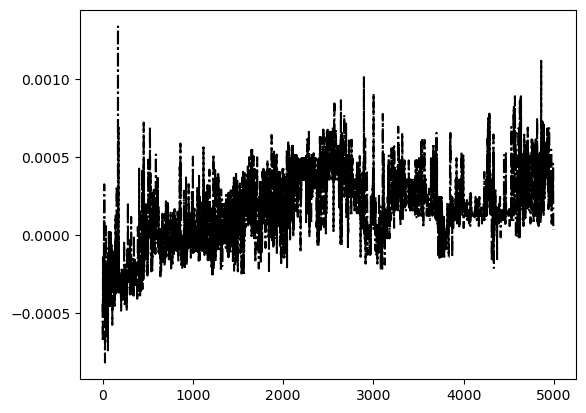

In [367]:
# Try clustering
from sklearn.cluster import KMeans
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn import metrics
delta = [1,3]
theta = [4,7]
alpha = [8,12]
beta = [13,30]
gamma = [30,100]
band = delta
# # If we want to inspect by frequency band
# low = np.argmin((Hz-band[0])**2)
# hi = np.argmin((Hz-band[1])**2)

# loop over small windows of frequencies
Rand_scores = []

for start in range(len(Hz)):
    low = start
    hi = start + 5
    
    if (len(Hz)-low) < 5:
        break
    
    # Organize the data for clustering
    xdat = []
    ydat = []
    for label in labels:
        mean_slice = np.mean(FFTs[label][low:hi,:,:], axis=0).T
        xdat.append(mean_slice)
        ydat.extend([label] * mean_slice.shape[0])
    xdat = np.vstack(xdat)
    ydat = np.array(ydat)

    # Encode labels
    label_encoder = LabelEncoder()
    y_encoded = label_encoder.fit_transform(ydat)

    # Performing K-Means clustering
    kmeans = KMeans(n_clusters=6, random_state=42)
    y_pred = kmeans.fit_predict(xdat)
    
    Rand_scores.append(metrics.adjusted_rand_score(y_encoded, y_pred))
    
#     conf_matrix = confusion_matrix(y_encoded, y_pred)
#     print("Confusion Matrix:")
#     print(conf_matrix)

plt.plot(Rand_scores,'k-.')
plt.plot()

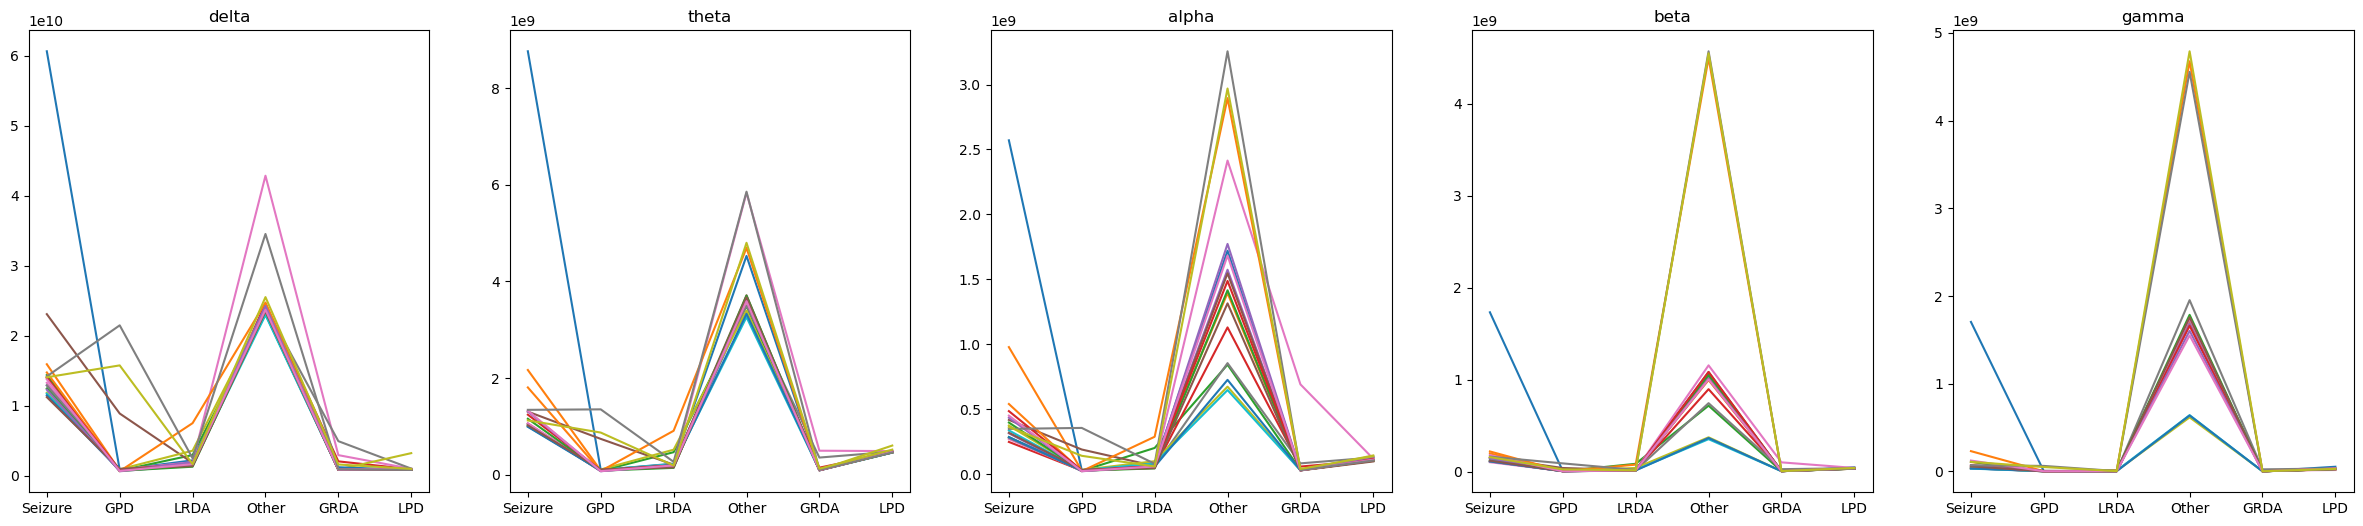

In [412]:
# Plot the means for each frequency band across the different types
delta = [1,3]
theta = [4,7]
alpha = [8,12]
beta = [13,30]
gamma = [30,100]
bands = [delta,theta,alpha,beta,gamma]
titles = ['delta','theta','alpha','beta','gamma']

# fig, ax = plt.subplots(1,5)
fig, ax = plt.subplots(1, 5, figsize=(30, 6))

for i, ax in enumerate(ax.flat):
    band = bands[i]
    low = np.argmin((Hz-band[0])**2)
    hi = np.argmin((Hz-band[1])**2)
    xdat = []
    xvar = []
    ydat = []

    for label in labels:
        mean_slice = np.mean(np.mean(FFTs[label][low:hi,:,:], axis=0).T,axis=0)
        var_slice = np.var(np.mean(FFTs[label][low:hi,:,:], axis=0).T,axis=0)
        xdat.append(mean_slice)
        xvar.append(var_slice)
        ydat.extend([label])

    xdat = np.vstack(xdat)
    xvar = np.vstack(xvar)
    ydat = np.array(ydat)

    # Plot the means/variances for all channels across the types of data
    for chan in range(np.shape(xdat)[1]):
        ax.plot(labels,xvar[:,chan],label=f'Channel {chan}')
        ax.set_title(titles[i])
        ax.set_aspect('auto')
        
# plt.legend()
plt.show()

# The following cells are for time frequency exploration

In [46]:
## For loading and computing TF on concatenated data - to be adapted
## Load a few sample datasets from each label.

from scipy.signal import stft
beg = time.time()
time_eeg = np.arange(-25, 25+ (1/200), (1/200))

labels = train.expert_consensus.unique()
numeegs = 100 # Number of datasets to load from each type
exploration = {}
TF_data = {}
ydata = []
# Hz = np.linspace(0,100,int((len(time_eeg)-1)/2+1))


for idx, label in enumerate(labels):
    tempid = train.eeg_id.where(train.expert_consensus == label).unique()
    tempid = tempid[~np.isnan(tempid)] # There were a few nans in there.
    chosen = np.random.choice(tempid,size=numeegs)
    
    
    for d in range(numeegs):
        path = f'{EEG_PATH}{int(chosen[d])}.parquet'
        fulleeg = loadeeg(path).to_numpy()[:,:19] # Excluding the ECG channel here
        offset = train.eeg_label_offset_seconds[train.eeg_id == chosen[d]].values
        f, t, TF = stft(fulleeg, fs=200, window='hann', nperseg=100, noverlap=50, 
                 detrend=False, return_onesided=True, boundary='zeros', padded=True, axis=0, scaling='psd')

        tempdat = np.zeros((len(time_eeg)-1,19,len(offset)))
        seglen = (np.argmin(np.abs(50-t)) - np.argmin(np.abs(0-t)))
        tempdat2 = np.zeros((len(f),19,seglen,len(offset)))
        

        for offind, off in enumerate(offset):
            if np.isnan(fulleeg[int(off)*200:(((int(off)+50)*200)),:]).any(): #Not sure why the nans are appearing.
                continue
            tempdat[:,:,offind] = fulleeg[int(off)*200:(((int(off)+50)*200)),:]
            start = np.argmin(np.abs(t-off))
            end = np.argmin(np.abs(t-(off+50)))         
            tempdat2[:,:,:,offind] = np.abs(TF[:,:,start:end])
        exploration[int(chosen[d])] = tempdat
        TF_data[int(chosen[d])] = tempdat2
        ydata.append(label)
done = time.time()
elap = done-beg
print(elap)

37.26710891723633


In [ ]:
# Adapt the above code to concatenate the data and then run a single TF transformation
# I thought this would be faster but its much slower. Probably because of the loops in the second half after the transformation
# Maybe this code can be improved to make it faster

beg = time.time()
labels = train.expert_consensus.unique()
numeegs = 50 # Number of datasets to load from each type
exploration = {}
ids = np.empty(0, dtype=int)  # Assuming IDs are integers
ydata = np.empty(0, dtype=int)
TF_data = {}
Hz = np.linspace(0,100,int((len(time_eeg)-1)/2+1))


for idx, label in enumerate(labels):
    tempid = train.eeg_id.where(train.expert_consensus == label).unique()
    tempid = tempid[~np.isnan(tempid)]  # Remove NaNs.
    chosen = np.random.choice(tempid, size=numeegs)
    ids = np.concatenate((ids, chosen))
    
    # Create an array of 'label' repeated 'numeegs' times
    labels_array = np.full((numeegs,), label)
    ydata = np.concatenate((ydata, labels_array))
 

eeg_t = np.zeros((1,))    
offsets = [np.empty((0,1), dtype=int)]
Parquet_lengths = np.empty(0, dtype=int)
EEG_data = np.empty((0,19), dtype=int)

for d in range(numeegs*len(labels)):
    path = f'{EEG_PATH}{int(ids[d])}.parquet'
    fulleeg = loadeeg(path).to_numpy()[:,:19] # Excluding the ECG channel here
    offsets.append(train.eeg_label_offset_seconds[train.eeg_id == ids[d]].values)
    Parquet_lengths = np.append(Parquet_lengths, int(fulleeg.shape[0]/200))
    EEG_data = np.concatenate((EEG_data,fulleeg),axis=0)
   
del offsets[0]
f, t, TF = stft(EEG_data, fs=200, window='hann', nperseg=100, noverlap=50, 
              detrend=False, return_onesided=True, boundary='zeros', padded=True, axis=0, scaling='psd')

temp = np.cumsum(Parquet_lengths)
matches = np.any(t[:, np.newaxis] == temp, axis=1)
indices = np.where(matches)[0]

# Check that we found all indices
assert len(indices) == len(temp)

for idx,thisparq in enumerate(indices):
    if idx == 0:
        fulltf = TF[:,:,1:indices[0]+1]
        cut_time = t[1:indices[0]+1]
    else:
        fulltf = TF[:,:,indices[idx-1]+1:indices[idx]+1]
        cut_time = t[indices[idx-1]+1:indices[idx]+1] - temp[idx-1]
    
    tempdat = np.zeros((len(f),19,np.where(t==50)[0][0],len(offsets[idx])))
    
    for offind in range(len(offsets[idx])):

        #        if np.isnan(fulltf[int(off)*200:(((int(off)+50)*200)),:]).any(): #Not sure why the nans are appearing.
        #            continue
        
        if int(offsets[idx][offind]) == 0:
            start = 0
            stop  = int(np.where(cut_time == int(offsets[idx][offind] + 50))[0])+1
        else:
            start = int(np.where(cut_time == int(offsets[idx][offind]))[0])      
            stop  = int(np.where(cut_time == int(offsets[idx][offind] + 50))[0])
        
        
        print(f'segment length:{stop-start}, fulltf shape: {fulltf.shape}, chunk shape: {fulltf[:,:,start+1:stop+1].shape},idx:{idx},offind:{offind}')
        if fulltf[:,:,start+1:stop+1].shape[2] == 199:
            tempdat[:,:,:,offind] = fulltf[:,:,start:stop+1]
        else:
            tempdat[:,:,:,offind] = fulltf[:,:,start+1:stop+1]
            
    TF_data[ids[idx]] = tempdat
    
finish = time.time()
elapsed2 = finish-beg
print(elapsed2)

(200,)

In [56]:
# Explore TF data
TFkeys = list(TF_data.keys())

# Compute subject averages
SEIZURE = np.empty((51, 19, 200, 0))
GPD = np.empty((51, 19, 200, 0))
LRDA = np.empty((51, 19, 200, 0))
OTHER = np.empty((51, 19, 200, 0))
LPD = np.empty((51, 19, 200, 0))
GRDA = np.empty((51, 19, 200, 0))

for idx,value in enumerate(TF_data.keys()):
    temp = np.mean(TF_data[value],axis=3)
    temp = temp[:, :,:, np.newaxis]  

    if ydata[idx] == 'Seizure':
        SEIZURE = np.append(SEIZURE,temp,axis = 3)
    elif ydata[idx] == 'GPD':
        GPD = np.append(GPD,temp,axis = 3)
    elif ydata[idx] == 'LRDA':
        LRDA = np.append(LRDA,temp,axis = 3)
    elif ydata[idx] == 'Other':
        OTHER = np.append(OTHER,temp,axis = 3)
    elif ydata[idx] == 'GRDA':
        GRDA = np.append(GRDA,temp,axis = 3)
    elif ydata[idx] == 'LPD':
        LPD = np.append(LPD,temp,axis = 3)


Spects = {}
Spects['Seizure'] = SEIZURE
Spects['GPD'] = GPD
Spects['LRDA'] = LRDA
Spects['Other'] = OTHER
Spects['GRDA'] = GRDA
Spects['LPD'] = LPD



In [84]:
# Compute a grand average
grandave = np.zeros((51, 19, 200))
for idx, label in enumerate(labels):
    temp = np.nanmean(Spects[label],axis=3)
    if np.any(np.isnan(temp)):
        print(label)
        continue
    grandave = grandave + temp
    
grandave = np.mean(grandave/6,axis = 2)

(51, 19, 200, 100)

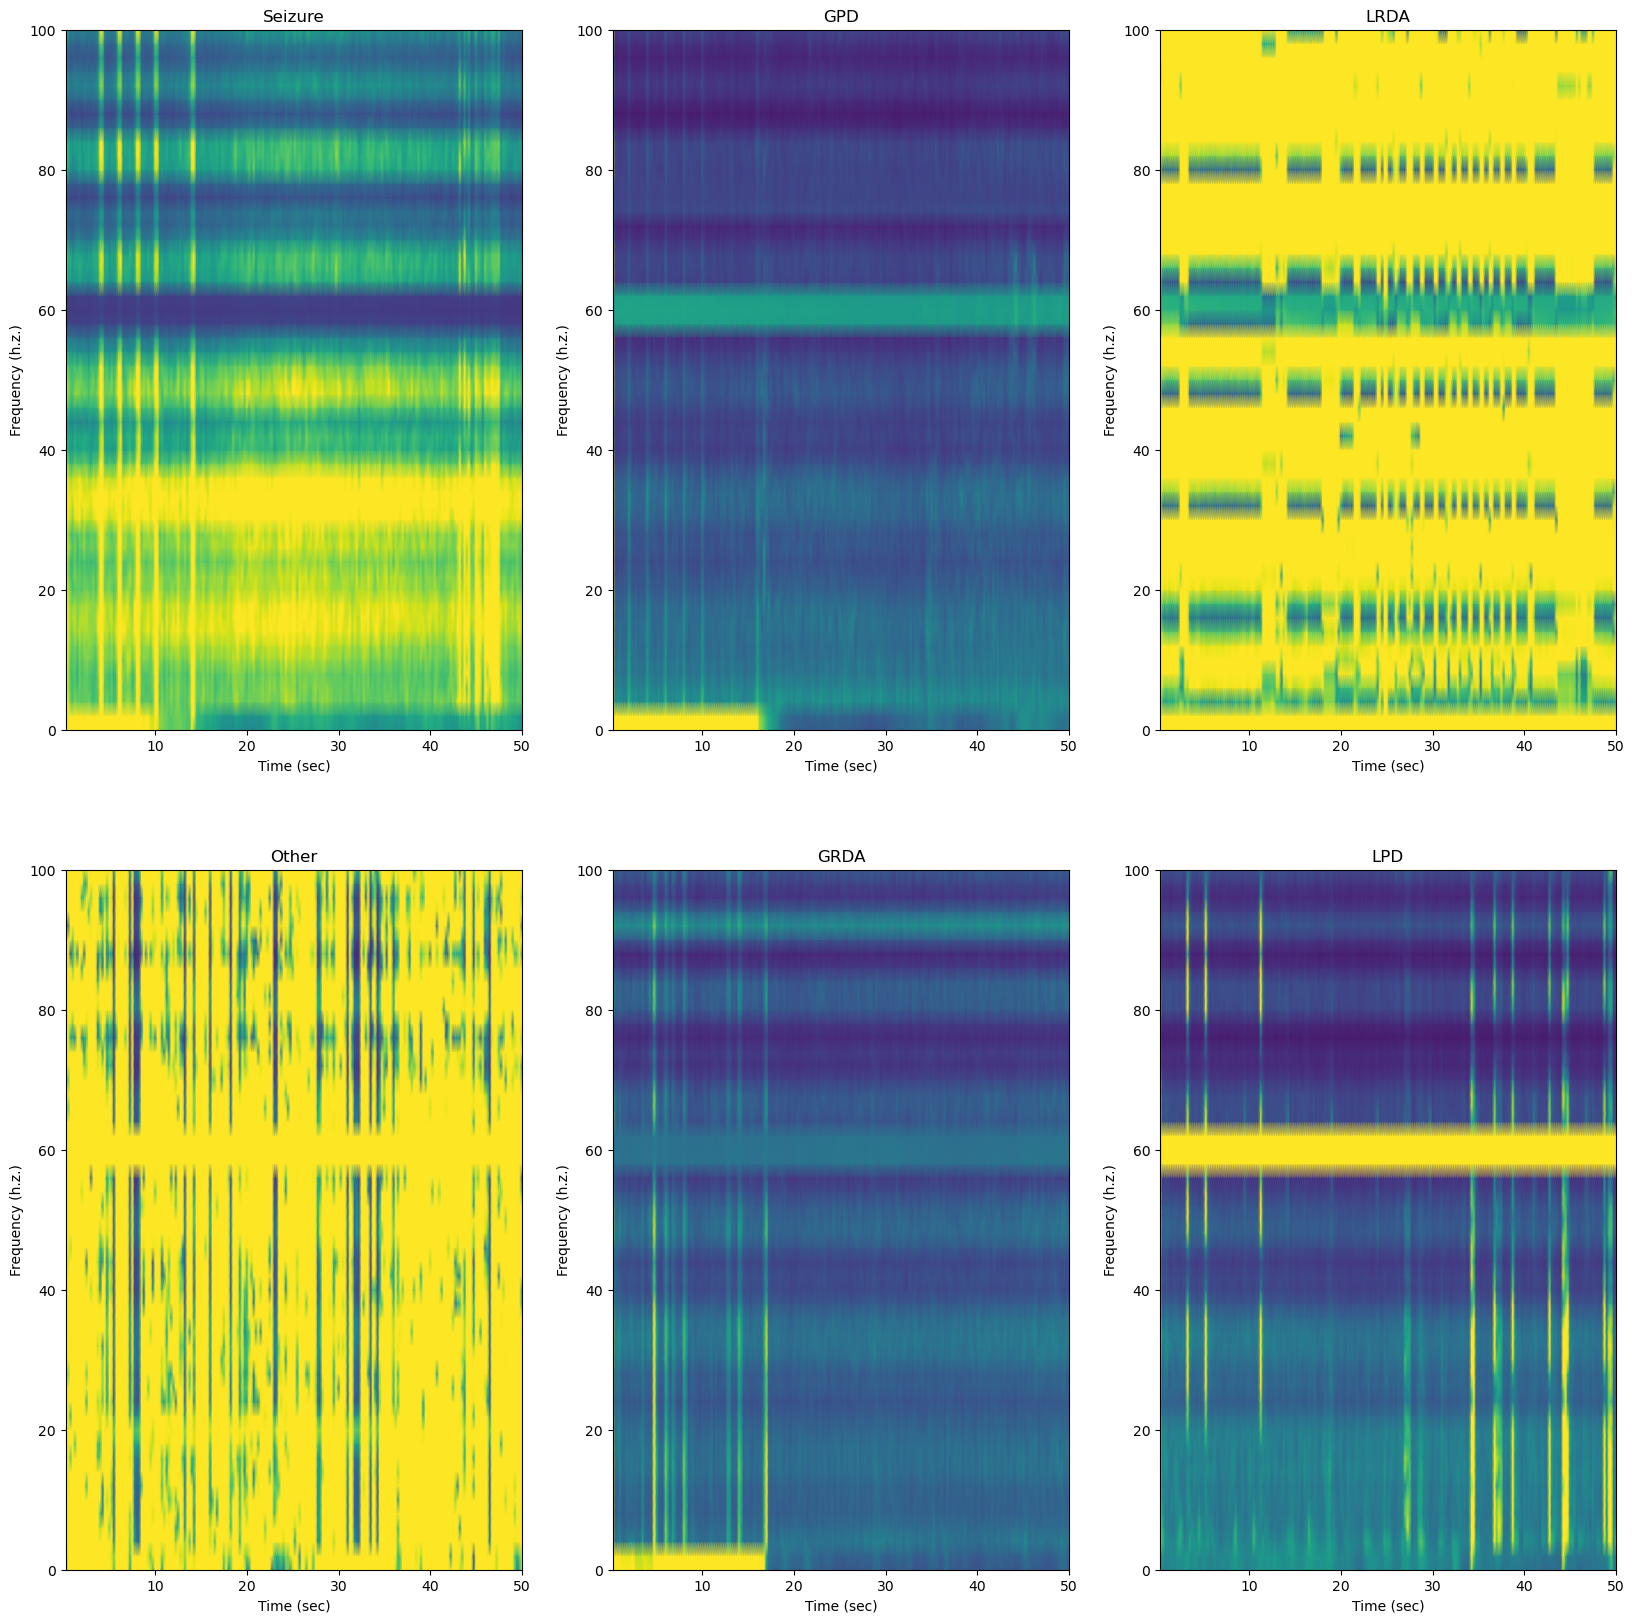

In [95]:
# Plot spectrograms for visual inspection

fig, axs = plt.subplots(2,3,figsize=(20, 20))
axes = axs.flatten()

for idx, label in enumerate(labels):
    dat = np.mean(Spects[label],axis=3)
    dat = dat / grandave[:, :, np.newaxis] # Normalize by the grand average
    axes[idx].pcolormesh(cut_time,f,dat[:,16,:],shading='gouraud',vmin=0,vmax=1)
    axes[idx].set_ylabel('Frequency (h.z.)')
    axes[idx].set_xlabel('Time (sec)')
    axes[idx].set_title(label)

plt.show()